In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from keras.utils.data_utils import Sequence
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Convolution2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

seed = 7
np.random.seed(seed)

DATA_DIR = "../data/"
NUM_CLASSES = 228
IMAGE_SIZE = 128

C:\Users\matt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%%time
with open(DATA_DIR + "train.json") as train, open(DATA_DIR + "test.json") as test, open(DATA_DIR + "validation.json") as validation:
    train_json = json.load(train)
    test_json = json.load(test)
    validation_json = json.load(validation)
    
def generate_paths_and_labels(json_obj, folder):
    paths, labels = [], []
    for data in json_obj['annotations']:
        label = [int(x) for x in data["labelId"]]
        image_path = DATA_DIR + "{}/id_{}_labels_{}.jpg".format(folder, data["imageId"], label)
        paths.append(image_path)
        temp_array = [0] * NUM_CLASSES
        for elem in data['labelId']:
            temp_array[int(elem) - 1] = 1
        labels.append(temp_array)
    return np.array(paths), np.array(labels)

train_paths, train_labels = generate_paths_and_labels(train_json, "train")
validation_paths, validation_labels = generate_paths_and_labels(validation_json, "validation")

Wall time: 22.4 s


20
66
70
95
137


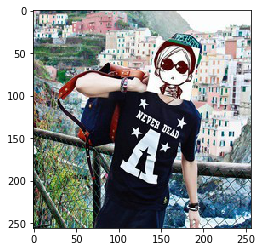

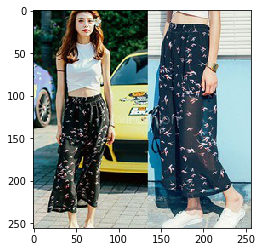

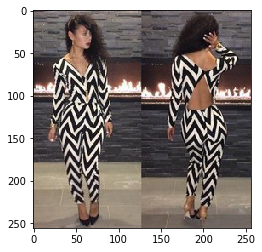

In [8]:
import random

TARGET_SIZE=(IMAGE_SIZE,IMAGE_SIZE)

def path_to_image(path):
    return np.array(Image.open(path))
    
rands = random.sample(range(1, len(train_paths)), 3)
paths = [train_paths[i] for i in rands]
images = [path_to_image(i) for i in paths]

# for i, elem in enumerate(train_labels[0]):
#     if elem == 1:
#         print(i + 1)
# print(train_labels[0])

for image in images:
    plt.imshow(image)
    plt.show()

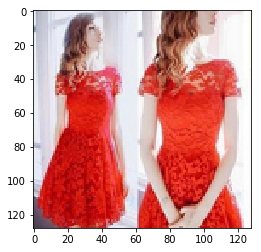

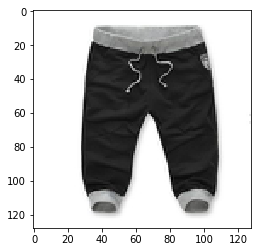

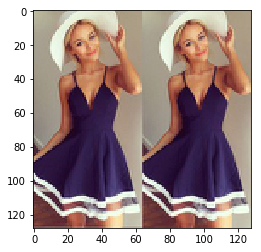

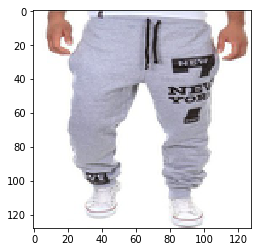

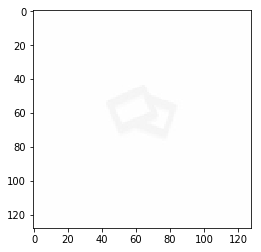

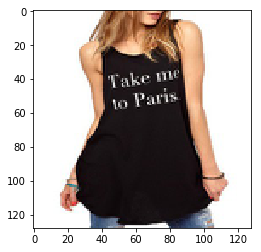

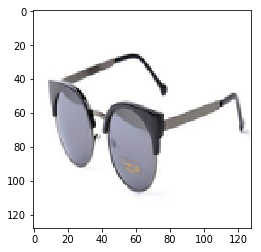

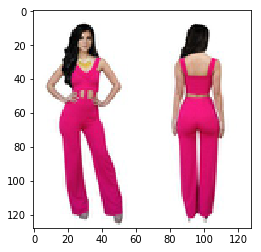

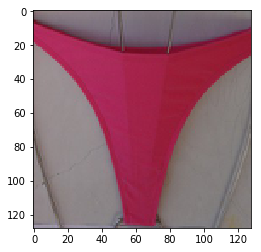

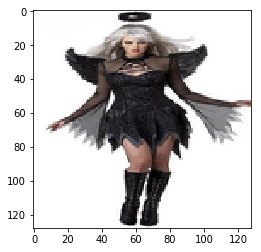

None


In [5]:
class BatchSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = np.empty([len(batch_x), IMAGE_SIZE, IMAGE_SIZE, 3], dtype='uint8')
        for i, path in enumerate(batch_x):
            try:
                img = Image.open(path)
                img.thumbnail((IMAGE_SIZE, IMAGE_SIZE))
                image = np.array(img)
            except Exception as e:
                print(e)
                output = [1]*(IMAGE_SIZE*IMAGE_SIZE*3)
                output = np.array(output).reshape(IMAGE_SIZE,IMAGE_SIZE,3).astype('uint8')
                image = Image.fromarray(output).convert('RGB')
            plt.imshow(image)
            plt.show()
            # images[i, ...] = image
        # return images, np.array(batch_y)  

test = BatchSequence(train_paths, train_labels, 10)

print(test.__getitem__(3))

In [9]:
class BatchSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = np.empty([len(batch_x), IMAGE_SIZE, IMAGE_SIZE, 3], dtype='uint8')
        for i, path in enumerate(batch_x):
            try:
                image = np.array(Image.open(path))
            except Exception as e:
                print(e)
                output = [1]*(IMAGE_SIZE*IMAGE_SIZE*3)
                output = np.array(output).reshape(IMAGE_SIZE,IMAGE_SIZE,3).astype('uint8')
                image = Image.fromarray(output).convert('RGB')
            images[i, ...] = image
        return images, np.array(batch_y)  

In [10]:
### https://github.com/suraj-deshmukh/Multi-Label-Image-Classification/blob/master/miml.ipynb
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3),padding='same',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# model.add(Dense(NUM_CLASSES, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 64)      18496     
__________

In [ ]:
# train_urls = train_urls[:50000]
# train_labels = train_labels[:50000]

# train_paths = train_paths[:250000]
# train_labels = train_labels[:250000]

EPOCHS = 5
BATCH = 32
STEPS = len(train_paths) // BATCH

train_gen = BatchSequence(train_paths, train_labels, BATCH)
val_gen = BatchSequence(validation_paths, validation_labels, BATCH)

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    generator = train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    steps_per_epoch = STEPS,
    callbacks = [checkpointer],
)

Epoch 1/5


In [ ]:
# TODO: write generator for test data
# def test_gen(X_test):
#     Y_trash = np.ones(X_test.shape[0])
#     flow = train_datagen.flow(X_test, Y_trash)
#     for X,Y in flow
#         yield X #ignore Y
# end

# model.predict_generator(test_gen(X_test),
#                         val_samples=X_test.shape[0]